In [214]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import json, os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam, SGD
from tqdm.auto import tqdm
import csv

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [97]:
seed = 42
np.random.seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
train_df = pd.read_csv("./datasets/datathon_2.0/train.csv")
test_df = pd.read_csv("./datasets/datathon_2.0/test.csv")

In [4]:
train_df.head()

,id,gender,s11,s12,s13,s16,s17,s18,s48,s52,s53,s54,s55,s56,s57,s58,s59,s69,s70,s71,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15,label
0,b'gAAAAABinOicS09vrmgh0_JyEHihI13ptO0rCyHP7l76...,M,Y,N,1,D,D,B,0,1,,NaN,kK,NaN,NaN,B,NaN,x,op: D,b,16.144666,1.989441,2,2.318385,-32.839277,0.017176,-9.126056,1.732291,3.698504,4.804517,1.544484,0,0,0.631220,5,0
1,b'gAAAAABinOiWGC1WhR6WYP0DA5ssGv9rIekrWUwCdJ8F...,M,Y,Y,1,D,D,B,1,1,,NaN,NaN,NaN,NaN,B,NaN,x,op: D,b,7.144558,0.844866,3,6.197768,-32.576597,0.013857,-9.098287,1.505885,6.791357,6.110416,1.712354,0,0,0.392746,3,1
2,b'gAAAAABinOibTcOBFIVeA4nVF3FuFz_QX3ZlPPFc21gS...,M,Y,Y,1,D,D,B,0,1,,NaN,NaN,NaN,NaN,B,NaN,x,op: D,b,6.923236,1.042018,6,7.824401,-32.510544,0.013943,-9.234894,1.503828,4.109685,3.953226,1.804260,0,0,0.222537,2,0
3,b'gAAAAABinOig-g3-Q1ggjlMhfUSdn21Aj5yVVeVvXbis...,F,Y,Y,1,D,D,B,0,1,,NaN,NaN,NaN,NaN,B,NaN,x,op: D,b,5.749840,0.781439,2,8.256767,-32.398679,0.010387,-9.378025,1.485863,7.265876,4.559419,1.537645,0,0,0.154409,4,0
4,b'gAAAAABinOiXdoaNUzihOSbyY1tjWtd5EgMaXkkvH6SV...,M,N,Y,1,B,D,D,1,l,,NaN,NaN,NaN,NaN,B,NaN,~1,op: D,d,14.771959,1.248188,3,2.300011,-32.396746,0.016289,-9.261962,1.619210,3.737647,4.052003,1.637831,0,1,0.737560,1,0


In [5]:
test_df.head()

,id,gender,s11,s12,s13,s16,s17,s18,s48,s52,s53,s54,s55,s56,s57,s58,s59,s69,s70,s71,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15
0,b'gAAAAABinOi328DZcweGB4_nOyHA3Dy6o1YKYKyf3COx...,M,Y,Y,1,B,D,D,0,l,,NaN,NaN,NaN,NaN,B,NaN,~1,op: D,d,17.362752,2.985283,3,2.052415,-32.339904,0.026301,-9.200175,2.122970,6.646617,4.801224,1.693087,0,0,0.439270,2
1,b'gAAAAABinOikutEIBjkUXl9lYTg4RI6jc4NfiMUCcVsn...,M,Y,Y,1,B,C,B,1,l,,NaN,NaN,NaN,NaN,A,NaN,~1,op: C,b,15.892228,2.389056,7,6.928142,-32.356092,0.010774,-8.897092,1.770889,11.046294,6.407230,1.516728,0,0,0.084334,4
2,b'gAAAAABinOjBM70jBXOroAlUSq5lNXMd_oP0PU7jLQE5...,M,Y,N,1,B,D,B,1,l,,NaN,NaN,NaN,NaN,B,NaN,~1,op: D,b,10.893303,1.470903,6,2.210629,-32.397871,0.016837,-9.173660,1.871872,2.805834,5.481219,1.788823,0,0,0.984210,0
3,b'gAAAAABinOimitAnqlgOcqnD_LeNL3WEbXNGvjd3QVPi...,M,Y,Y,1,D,D,B,0,1,,NaN,NaN,NaN,NaN,B,NaN,x,op: D,b,9.876850,1.442493,3,2.350379,-32.836003,0.015684,-9.178200,1.675028,6.354938,5.427266,1.792147,0,0,0.003492,1
4,b'gAAAAABinOi3W9p3Oka5MV_dc2TeorZUcIWOnnODSx7E...,M,Y,Y,1,D,C,B,1,1,,NaN,kk,NaN,NaN,B,NaN,x,op: C,b,11.674406,2.544719,8,8.136887,-32.577495,0.006406,-8.726633,1.963535,6.810158,11.487845,1.880992,0,0,0.060614,0


In [6]:
train_df.isnull().sum()

id            0
gender        0
s11           0
s12           0
s13           0
s16           0
s17           0
s18           0
s48           0
s52           0
s53           0
s54       25694
s55       25116
s56       28322
s57       28322
s58           0
s59       28322
s69           0
s70           0
s71           0
n1            0
n2            0
n3            0
n4            0
n5            0
n6            0
n7            0
n8            0
n9            0
n10           0
n11           0
n12           0
n13           0
n14           0
n15           0
label         0
dtype: int64

### Dropping null and less important columns

In [7]:
cols_to_drop = ['id', 'n3', 'n15', 'n12', 'n13', 's11', 's12', 's58', 's69', 's70', 's71', 's13',	's16',	's17',	's18',	's48',	's52',	's53', 's54', 's55', 's56', 's57', 's59']
train_df = train_df.drop(labels=cols_to_drop, axis=1).copy()
test_df = test_df.drop(labels=cols_to_drop, axis=1).copy()

In [8]:
train_df.isnull().sum()

gender    0
n1        0
n2        0
n4        0
n5        0
n6        0
n7        0
n8        0
n9        0
n10       0
n11       0
n14       0
label     0
dtype: int64

In [9]:
test_df.isnull().sum()

gender    0
n1        0
n2        0
n4        0
n5        0
n6        0
n7        0
n8        0
n9        0
n10       0
n11       0
n14       0
dtype: int64

In [10]:
train_df['gender'] = train_df['gender'].map({'M': 0, 'F': 1})
test_df['gender'] = test_df['gender'].map({'M': 0, 'F': 1})

### Target labels distribution

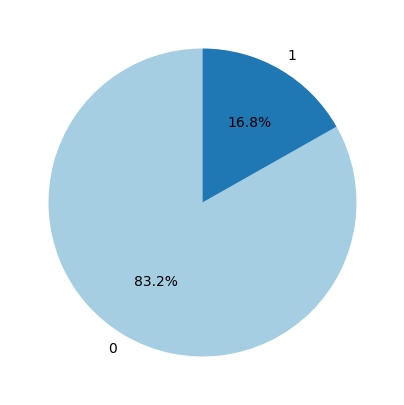

In [11]:
label_counts = train_df['label'].value_counts()
label_percentage = (label_counts / len(train_df)) * 100

plt.figure(figsize=(5, 5))
plt.pie(
    x=label_percentage,
    labels=label_percentage.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)
plt.show()

In [12]:
train_labels = train_df['label']
train_df = train_df.drop(labels=['label'], axis=1).copy()

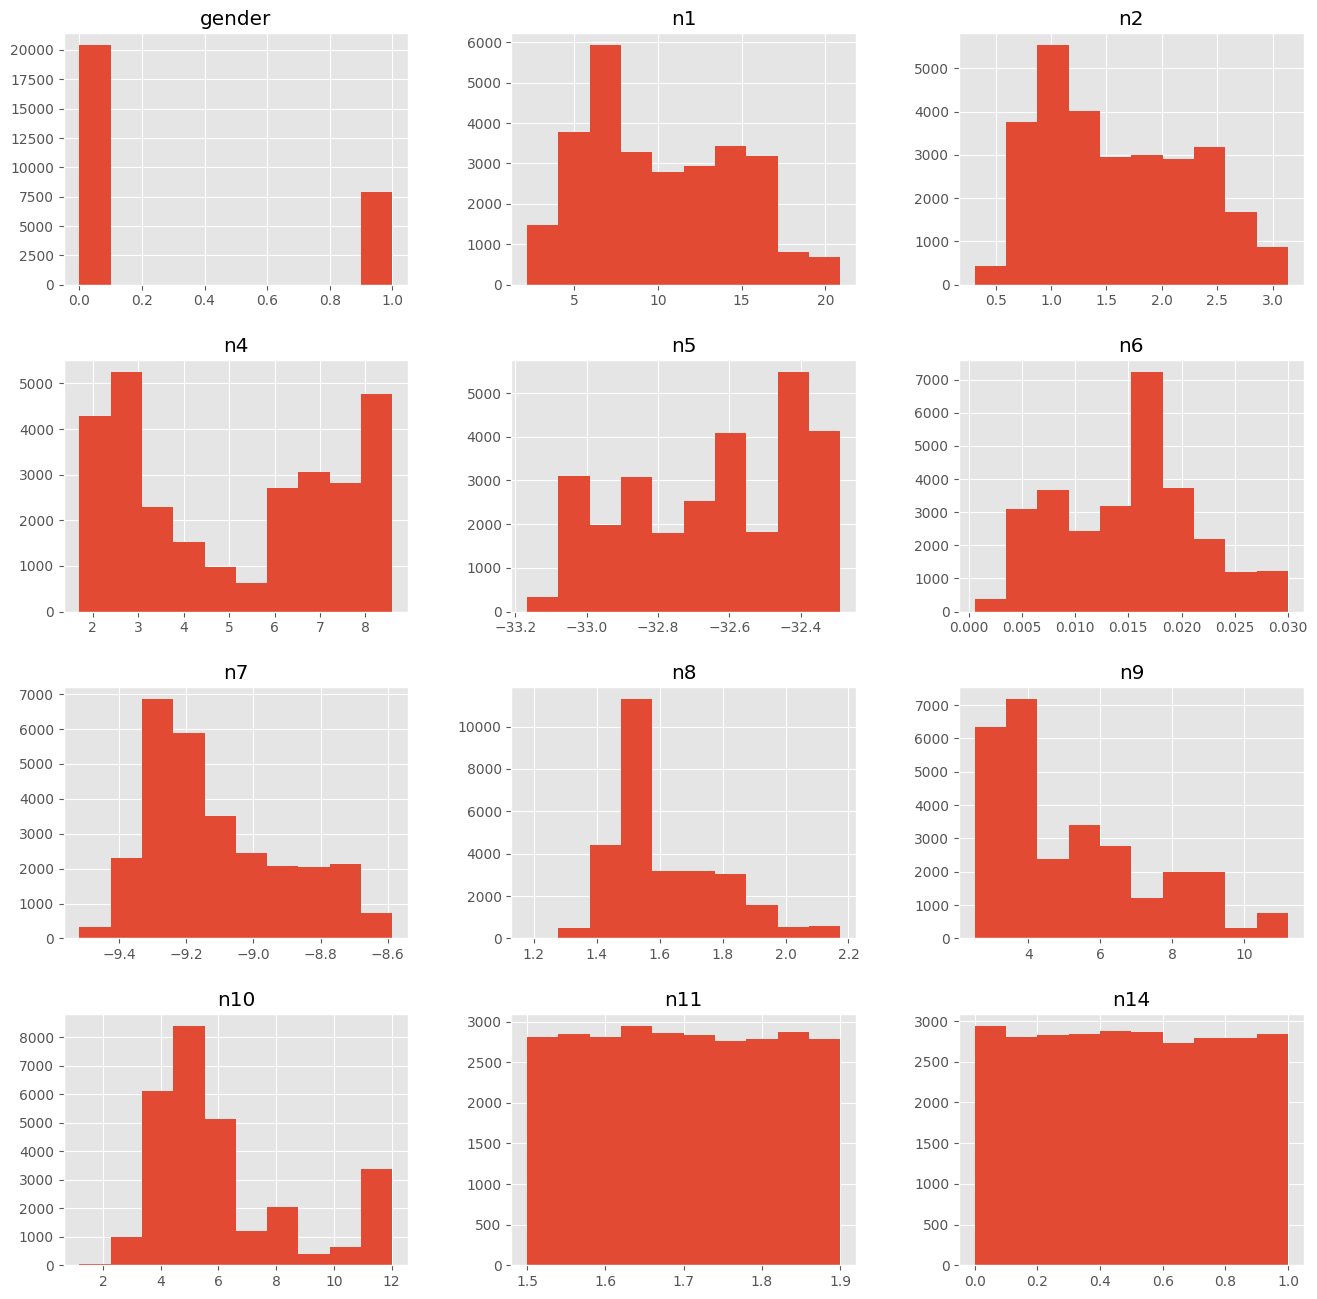

In [13]:
train_df.hist(figsize=(16, 16))
plt.show()

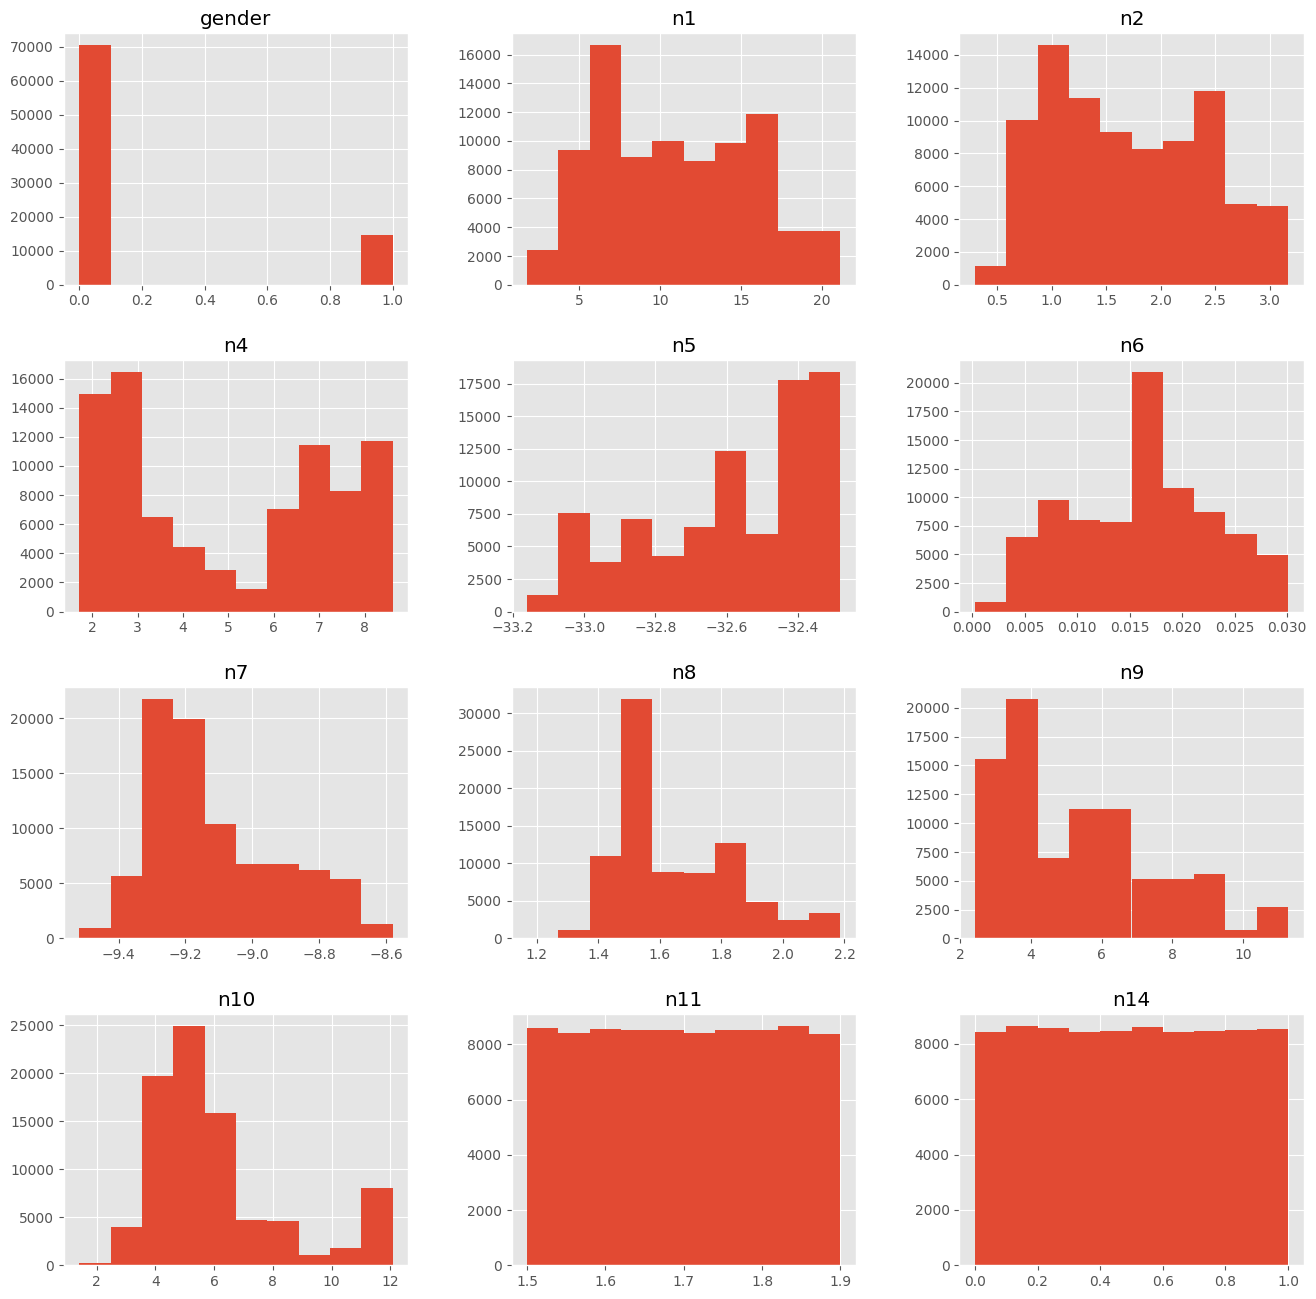

In [14]:
test_df.hist(figsize=(16, 16))
plt.show()

### Normalize dataset (min-max)

In [15]:
train_df = (train_df - train_df.min()) / (train_df.max() - train_df.min())
test_df = (test_df - test_df.min()) / (test_df.max() - test_df.min())

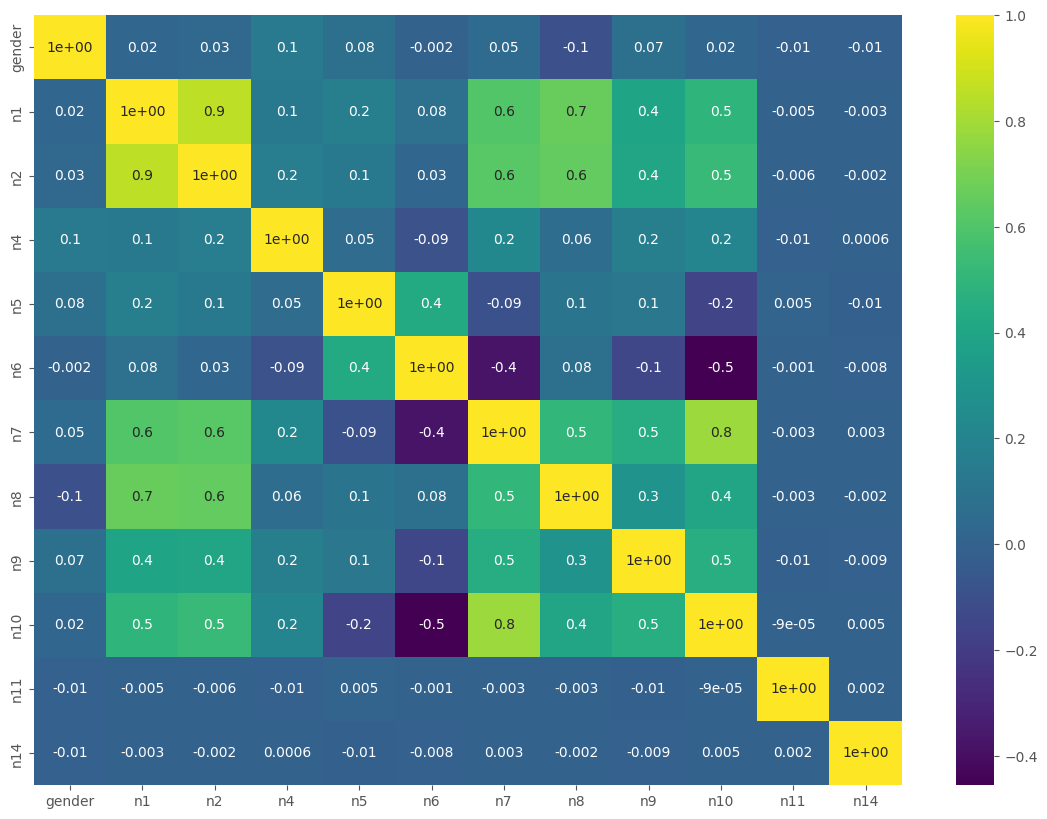

In [16]:
df_corr = train_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(df_corr, cmap='viridis', annot=True, fmt='.1')
plt.show()

### Drop correlated cols

In [17]:
cols_to_drop = ['n2', 'n10']
train_df = train_df.drop(labels=cols_to_drop, axis=1).copy()
test_df = test_df.drop(labels=cols_to_drop, axis=1).copy()

### Train and validation split

In [18]:
X, y = train_df, train_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

In [19]:
def find_optimal_model(clf, params):
    clf = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=2, verbose=3)
    clf.fit(X_train, y_train)
    
    best_params = clf.best_params_
    best_estimator = clf.best_estimator_
    
    return best_params, best_estimator

In [33]:
def save_result(filename: str, result_dict):
    result_dir = "./datathon_resutls"
    with open(os.path.join(result_dir, f'{filename}.json'), 'w') as f:
        json.dump(result_dict, f, indent=4)
        
        
def get_result(model_name, clf):
    y_preds = clf.predict(X=X_val)
    print(classification_report(y_val, y_preds))
    clf_result_dict = classification_report(y_val, y_preds, output_dict=True)
    save_result(filename=model_name, result_dict=clf_result_dict)

    cm = confusion_matrix(y_val, y_preds)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    plt.show()

### SVM

In [20]:
params = {
    'C': [1, 3, 5],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
}
best_params, best_svc = find_optimal_model(clf=SVC(), params=params)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END .........C=1, degree=2, kernel=rbf;, score=0.850 total time=   4.1s
[CV 2/2] END .........C=1, degree=2, kernel=rbf;, score=0.848 total time=   4.8s
[CV 1/2] END ........C=1, degree=2, kernel=poly;, score=0.832 total time=   3.7s
[CV 2/2] END ........C=1, degree=2, kernel=poly;, score=0.832 total time=   3.8s
[CV 1/2] END .....C=1, degree=2, kernel=sigmoid;, score=0.712 total time=   3.2s
[CV 2/2] END .....C=1, degree=2, kernel=sigmoid;, score=0.714 total time=   3.2s
[CV 1/2] END .........C=1, degree=3, kernel=rbf;, score=0.850 total time=   4.0s
[CV 2/2] END .........C=1, degree=3, kernel=rbf;, score=0.848 total time=   4.0s
[CV 1/2] END ........C=1, degree=3, kernel=poly;, score=0.848 total time=   9.3s
[CV 2/2] END ........C=1, degree=3, kernel=poly;, score=0.845 total time=   9.4s
[CV 1/2] END .....C=1, degree=3, kernel=sigmoid;, score=0.712 total time=   3.2s
[CV 2/2] END .....C=1, degree=3, kernel=sigmoid;

/home/atiqur/venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


              precision    recall  f1-score   support

           0       0.85      0.99      0.92      4713
           1       0.74      0.15      0.25       952

    accuracy                           0.85      5665
   macro avg       0.80      0.57      0.58      5665
weighted avg       0.83      0.85      0.80      5665



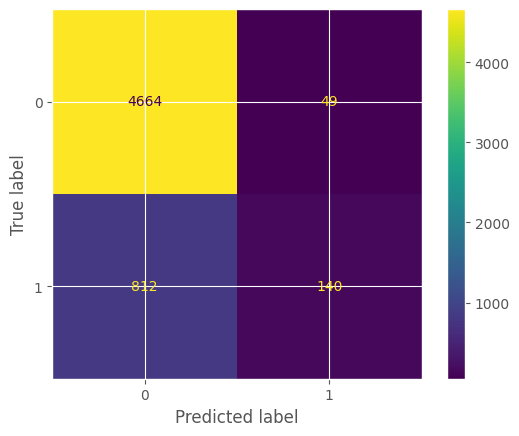

In [35]:
get_result(model_name='svm', clf=best_svc)

### KNN

In [22]:
params = {
    'weights': ['uniform', 'distance'],
    'n_neighbors': np.arange(3, 15),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}
best_params, best_knn = find_optimal_model(clf=KNeighborsClassifier(), params=params)

Fitting 2 folds for each of 96 candidates, totalling 192 fits
[CV 1/2] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.816 total time=   0.8s
[CV 2/2] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.818 total time=   0.8s
[CV 1/2] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.815 total time=   0.4s
[CV 2/2] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.817 total time=   0.4s
[CV 1/2] END algorithm=auto, n_neighbors=4, weights=uniform;, score=0.838 total time=   0.8s
[CV 2/2] END algorithm=auto, n_neighbors=4, weights=uniform;, score=0.838 total time=   0.8s
[CV 1/2] END algorithm=auto, n_neighbors=4, weights=distance;, score=0.813 total time=   0.4s
[CV 2/2] END algorithm=auto, n_neighbors=4, weights=distance;, score=0.819 total time=   0.4s
[CV 1/2] END algorithm=auto, n_neighbors=5, weights=uniform;, score=0.833 total time=   0.8s
[CV 2/2] END algorithm=auto, n_neighbors=5, weights=uniform;, score=0.834 total time=   0.9s
[CV 

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      4713
           1       0.64      0.19      0.29       952

    accuracy                           0.85      5665
   macro avg       0.75      0.58      0.60      5665
weighted avg       0.82      0.85      0.81      5665



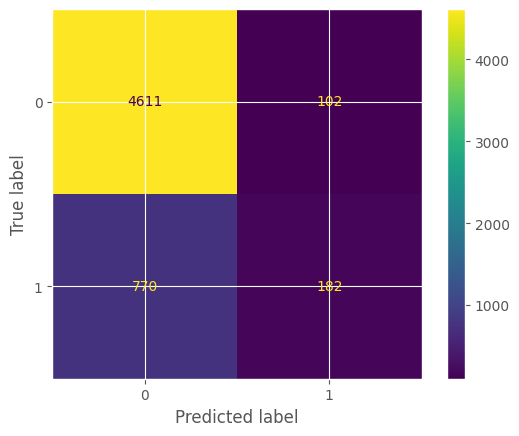

In [36]:
get_result(model_name='knn', clf=best_knn)

### Decision Tree

In [37]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}
best_params, best_dt = find_optimal_model(clf=DecisionTreeClassifier(), params=params)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=2, splitter=best;, score=0.846 total time=   0.1s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=2, splitter=best;, score=0.845 total time=   0.1s
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=2, splitter=random;, score=0.839 total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=2, splitter=random;, score=0.838 total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=5, splitter=best;, score=0.846 total time=   0.1s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=5, splitter=best;, score=0.845 total time=   0.1s
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=5, splitter=random;, score=0.842 total time=   0.0s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=5, splitter=random;, score=0.843 total time=   0.0s
[CV 1/2] END criterion=gini, max_depth=5, min_samp

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      4713
           1       0.67      0.15      0.25       952

    accuracy                           0.85      5665
   macro avg       0.76      0.57      0.58      5665
weighted avg       0.82      0.85      0.80      5665



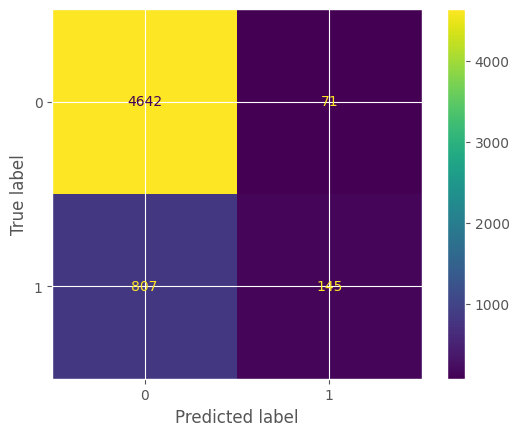

In [38]:
get_result(model_name='decision_tree', clf=best_dt)

### Random forest

In [40]:
params = {
    'n_estimators': [5, 10, 15, 20, 25, 30],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}
best_params, best_random_forest = find_optimal_model(clf=RandomForestClassifier(), params=params)

Fitting 2 folds for each of 216 candidates, totalling 432 fits
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=2, n_estimators=5;, score=0.849 total time=   0.1s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=2, n_estimators=5;, score=0.844 total time=   0.1s
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=2, n_estimators=10;, score=0.847 total time=   0.1s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=2, n_estimators=10;, score=0.848 total time=   0.1s
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=2, n_estimators=15;, score=0.849 total time=   0.2s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=2, n_estimators=15;, score=0.848 total time=   0.2s
[CV 1/2] END criterion=gini, max_depth=5, min_samples_split=2, n_estimators=20;, score=0.848 total time=   0.3s
[CV 2/2] END criterion=gini, max_depth=5, min_samples_split=2, n_estimators=20;, score=0.847 total time=   0.3s
[CV 1/2] END criterion=gini, max_depth=5, m

/home/atiqur/venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4713
           1       0.71      0.23      0.34       952

    accuracy                           0.85      5665
   macro avg       0.79      0.60      0.63      5665
weighted avg       0.84      0.85      0.82      5665



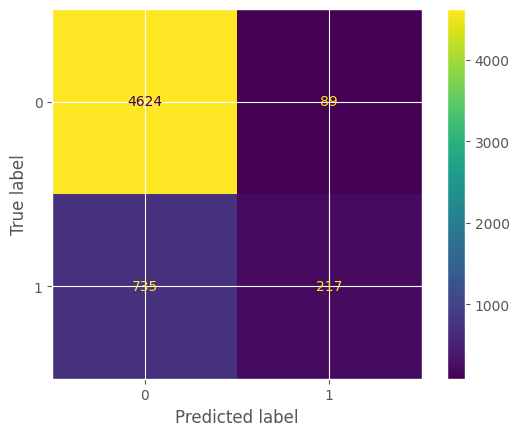

In [41]:
get_result(model_name='random_forest', clf=best_random_forest)

### Gradient Boosting

In [44]:
params = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [10, 15, 20],
    'n_estimators': [20, 30, 50],
    'criterion': ['friedman_mse', 'squared_error']
}
best_params, best_gb = find_optimal_model(clf=GradientBoostingClassifier(), params=params)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV 1/2] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=10, n_estimators=20;, score=0.832 total time=   2.7s
[CV 2/2] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=10, n_estimators=20;, score=0.832 total time=   2.6s
[CV 1/2] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=10, n_estimators=30;, score=0.832 total time=   4.0s
[CV 2/2] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=10, n_estimators=30;, score=0.832 total time=   4.0s
[CV 1/2] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=10, n_estimators=50;, score=0.832 total time=   6.8s
[CV 2/2] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=10, n_estimators=50;, score=0.832 total time=   6.8s
[CV 1/2] END criterion=friedman_mse, learning_rate=0.01, loss=log_loss, max_depth=15, n_estimators=20;, score=0.832 total time=

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      4713
           1       0.68      0.24      0.35       952

    accuracy                           0.85      5665
   macro avg       0.77      0.61      0.63      5665
weighted avg       0.83      0.85      0.82      5665



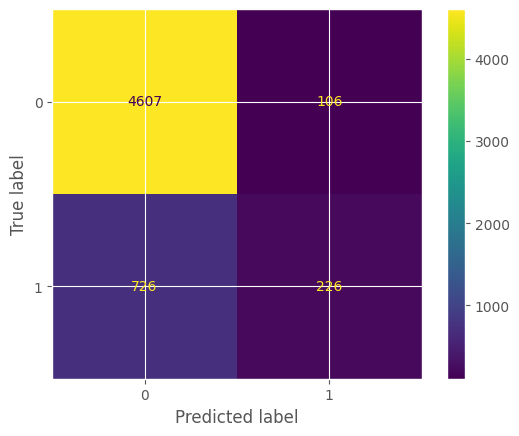

In [50]:
get_result(model_name='gradient_boosting', clf=best_gb)

### AdaBoost

In [54]:
params = {
    'estimator': [DecisionTreeClassifier()],
    'learning_rate': [0.01, 0.1, 1.0],
    'n_estimators': [20, 30, 50, 100, 150],
    'algorithm': ['SAMME']
}
best_params, best_ada_boost = find_optimal_model(clf=AdaBoostClassifier(), params=params)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 1/2] END algorithm=SAMME, estimator=DecisionTreeClassifier(), learning_rate=0.01, n_estimators=20;, score=0.771 total time=   0.2s
[CV 2/2] END algorithm=SAMME, estimator=DecisionTreeClassifier(), learning_rate=0.01, n_estimators=20;, score=0.778 total time=   0.2s
[CV 1/2] END algorithm=SAMME, estimator=DecisionTreeClassifier(), learning_rate=0.01, n_estimators=30;, score=0.770 total time=   0.2s
[CV 2/2] END algorithm=SAMME, estimator=DecisionTreeClassifier(), learning_rate=0.01, n_estimators=30;, score=0.779 total time=   0.2s
[CV 1/2] END algorithm=SAMME, estimator=DecisionTreeClassifier(), learning_rate=0.01, n_estimators=50;, score=0.772 total time=   0.2s
[CV 2/2] END algorithm=SAMME, estimator=DecisionTreeClassifier(), learning_rate=0.01, n_estimators=50;, score=0.775 total time=   0.2s
[CV 1/2] END algorithm=SAMME, estimator=DecisionTreeClassifier(), learning_rate=0.01, n_estimators=100;, score=0.773 total time= 

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      4713
           1       0.37      0.40      0.38       952

    accuracy                           0.78      5665
   macro avg       0.62      0.63      0.63      5665
weighted avg       0.79      0.78      0.79      5665



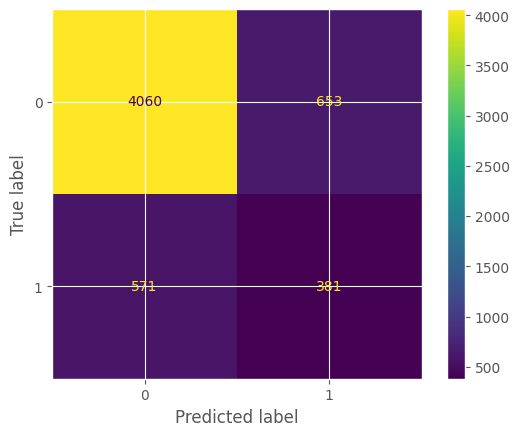

In [55]:
get_result(model_name='ada_boosting', clf=best_ada_boost)

### LGBM

In [73]:
params = {
    'max_depth': [10, 20, 30, 40],
    'learning_rate': [0.01, 0.1, 1.0],
}
best_params, best_lgbmboost = find_optimal_model(clf=LGBMClassifier(), params=params)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 1904, number of negative: 9424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 11328, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.168079 -> initscore=-1.599303
[LightGBM] [Info] Start training from score -1.599303
[CV 1/2] END ..learning_rate=0.01, max_depth=10;, score=0.844 total time=   0.1s
[LightGBM] [Info] Number of positive: 1904, number of negative: 9425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 11329, number of used features: 10
[LightGB

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      4713
           1       0.69      0.26      0.38       952

    accuracy                           0.86      5665
   macro avg       0.78      0.62      0.65      5665
weighted avg       0.84      0.86      0.83      5665



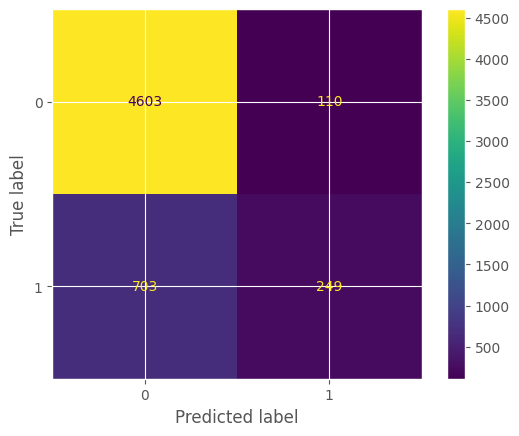

In [74]:
get_result(model_name='lgbmboost', clf=best_lgbmboost)

### Deep learning

In [95]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [151]:
class DatathonDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = list(y)
    
    def __len__(self):
        return len(self.y)
    
    
    def __getitem__(self, index):
        features = torch.tensor(self.X.iloc[index].tolist())
        label = torch.tensor(self.y[index])
        
        return features, label

In [152]:
train_set = DatathonDataset(X_train, y_train)
val_set = DatathonDataset(X_val, y_val)

### Model

In [239]:
class MLP(nn.Module):
    def __init__(self, inp_feature) -> None:
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=inp_feature, out_features=5, bias=False),
            nn.BatchNorm1d(num_features=5),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=5, out_features=2, bias=True)
        )
        
    def forward(self, x):
        out = self.layers(x)
        return out

### Hyperparameters

In [240]:
batch_size = 32
lr = 0.0001
num_epoch = 150

In [241]:
train_loader = DataLoader(train_set, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=os.cpu_count() // 2,
                          pin_memory=True)

val_loader = DataLoader(val_set, 
                          batch_size=batch_size, 
                          shuffle=False, 
                          drop_last=True,
                          num_workers=os.cpu_count() // 2,
                          pin_memory=True)

In [242]:
model = MLP(inp_feature=10).to(DEVICE)

In [243]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=lr)

In [244]:
def train(loader: DataLoader, is_train=True):
    
    predictions = []
    y_true = []
    with torch.set_grad_enabled(is_train):
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            out = model(x)
            loss = criterion(out, y)
            
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            preds = torch.argmax(out, dim=1).detach().cpu().tolist()
            y_true.extend(y.cpu().tolist())
            predictions.extend(preds)
        
    return loss.item(), accuracy_score(y_true, predictions)

In [245]:
progress_bar = tqdm(range(num_epoch))
csv_name = "./datathon_resutls/train_logs.csv"

with open(csv_name, 'w') as f:
    fnames = ['Epoch', 'Train_loss', 'Train_acc', 'Val_loss', 'Val_acc']
    writer = csv.DictWriter(f, fieldnames=fnames)
    writer.writeheader()

for epoch in progress_bar:
    train_loss, train_acc = train(train_loader, is_train=True)
    val_loss, val_acc = train(val_loader, is_train=False)
    
    progress_bar.set_postfix({
        "Train Loss": f"{train_loss:.3f}",
        "Train Acc": f"{train_acc:.2f}",
        "Val Loss": f"{val_loss:.3f}",
        "Val Acc": f"{val_acc:.2f}"
    })
    
    with open(csv_name, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, train_loss, train_acc, val_loss, val_acc])

  0%|          | 0/150 [00:00<?, ?it/s]

In [262]:
print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}")

Train Loss: 0.610 | Train Acc: 0.83 | Val Loss: 0.601 | Val Acc: 0.83


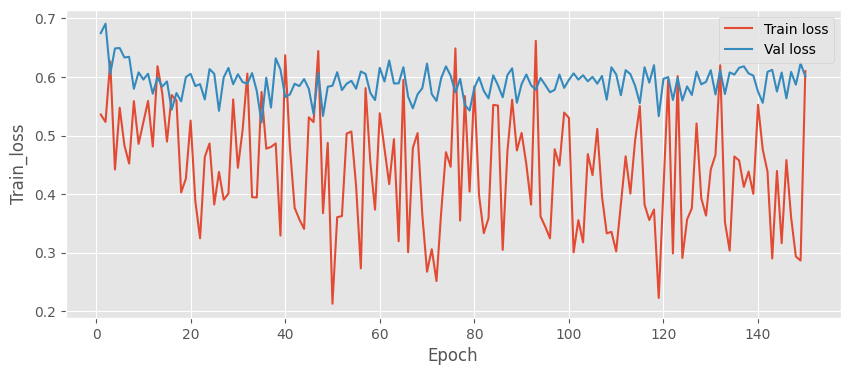

In [257]:
train_stats = pd.read_csv("./datathon_resutls/train_logs.csv")

plt.figure(figsize=(10, 4))
sns.lineplot(data=train_stats,
         x='Epoch',
         y='Train_loss',
         label='Train loss')

sns.lineplot(data=train_stats,
         x='Epoch',
         y='Val_loss',
         label='Val loss')

plt.legend()
plt.show()